# Create, evaluate, and score a text classification model

## Introduction

This notebook demonstrates Microsoft Fabric end-to-end data science workflow for a text classification model. The scenario is to use word2vec and logistic regression on Spark to determine a book's genre from the British Library book dataset solely based on the book's title.

The main steps in this notebook are:

1. Install custom libraries
2. Load the data
3. Understand and process the data using exploratory data analysis
4. Train a machine learning model using `word2vec` and logistic regression and track experiments using MLflow and Fabric Autologging feature
5. Load the machine learning model for scoring and make predictions

## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

## Step 1: Install custom libraries

When developing a machine learning model or doing ad-hoc data analysis, you may need to quickly install a custom library (e.g., `wordcloud` in this notebook) for the Apache Spark session. To do this, there are two choices.

1. You can use the in-line installation capabilities (e.g., `%pip`, `%conda`, etc.) to quickly get started with new libraries. Note that this installation option would install the custom libraries only in the current notebook and not in the workspace.
```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
 
```
2. Alternatively, you can create a Fabric environment, install libraries from public sources or upload custom libraries to it, and then your workspace admin can attach the environment as the default for the workspace. All the libraries in the environment will then become available for use in any notebooks and Spark job definitions in the workspace. For more information on environments, see [create, configure, and use an environment in Microsoft Fabric](https://aka.ms/fabric/create-environment).

For the classification model in this notebook, you'll need to use the `wordcloud` library to represent the frequency of words in a text where the size of the word represents its frequency. Here, you'll use `%pip install` to install `wordcloud`.

Note that the PySpark kernel will be restarted after `%pip install`, thus you'll need to install the library before you run any other cells.



In [ ]:
# Install wordcloud for text visualization using pip
%pip install wordcloud

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 21, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-7e57f2fc-5903-4e46-a241-9ef5462f313c/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Load the data

### Dataset 

The dataset is from the British Library book dataset and comprises of metadata about books that have been digitized through collaboration between the British Library and Microsoft. The dataset consists of classifications, created by humans to indicate whether a book is "fiction" or "nonfiction." With this dataset, the goal is to train a classification model that determines a book's genre solely based on its title.

|BL record ID|Type of resource|Name|Dates associated with name|Type of name|Role|All names|Title|Variant titles|Series title|Number within series|Country of publication|Place of publication|Publisher|Date of publication|Edition|Physical description|Dewey classification|BL shelfmark|Topics|Genre|Languages|Notes|BL record ID for physical resource|classification_id|user_id|created_at|subject_ids|annotator_date_pub|annotator_normalised_date_pub|annotator_edition_statement|annotator_genre|annotator_FAST_genre_terms|annotator_FAST_subject_terms|annotator_comments|annotator_main_language|annotator_other_languages_summaries|annotator_summaries_language|annotator_translation|annotator_original_language|annotator_publisher|annotator_place_pub|annotator_country|annotator_title|Link to digitized book|annotated|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|014602826|Monograph|Yearsley, Ann|1753-1806|person||More, Hannah, 1745-1833 [person]; Yearsley, Ann, 1753-1806 [person]|Poems on several occasions [With a prefatory letter by Hannah More.]||||England|London||1786|Fourth edition MANUSCRIPT note|||Digital Store 11644.d.32|||English||003996603||||||||||||||||||||||False|
|014602830|Monograph|A, T.||person||Oldham, John, 1653-1683 [person]; A, T. [person]|A Satyr against Vertue. (A poem: supposed to be spoken by a Town-Hector [By John Oldham. The preface signed: T. A.])||||England|London||1679||15 pages (4°)||Digital Store 11602.ee.10. (2.)|||English||000001143||||||||||||||||||||||False|


### Download dataset and upload to lakehouse

> [!TIP]
> By defining the following parameters, you can apply this notebook on different datasets easily.


In [ ]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually by user
DATA_FOLDER = "Files/title-genre-classification"
DATA_FILE = "blbooksgenre.csv"

# Data schema
TEXT_COL = "Title"
LABEL_COL = "annotator_genre"
LABELS = ["Fiction", "Non-fiction"]

EXPERIMENT_NAME = "sample-aisample-textclassification"  # MLflow experiment name

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 23, Finished, Available)

The following code downloads a publicly available version of the dataset and then store it in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [ ]:
if not IS_CUSTOM_DATA:
    # Download demo data files into lakehouse if it does not exist
    import os, requests

    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Title_Genre_Classification"
    fname = "blbooksgenre.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        # Add a lakehouse if no default lakehouse has been added to the notebook
        # A new notebook will not link to any lakehouse by default
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 24, Finished, Available)

Downloaded demo data files into lakehouse.


### Import required libraries

Prior to any processing, you need to import required libraries including those for [Spark](https://spark.apache.org/) and [SynapseML](https://aka.ms/AboutSynapseML).

In [ ]:
import numpy as np
from itertools import chain

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)

from synapse.ml.stages import ClassBalancer
from synapse.ml.train import ComputeModelStatistics

import mlflow

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 25, Finished, Available)

### Define hyperparameters

Define some hyperparameters for model training.

>[!IMPORTANT]
> Only modify these hyperparameters if you have an understanding of each parameter.

In [ ]:
# Hyper-parameters 
word2vec_size = 128  # The length of the vector for each word
min_word_count = 3  # The minimum number of times that a word must appear to be considered
max_iter = 10  # The maximum number of training iterations
k_folds = 3  # The number of folds for cross-validation

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 26, Finished, Available)

Start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 27, Finished, Available)

### Set up the MLflow experiment tracking

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. To learn more about  autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).

In [ ]:
# Set up Mlflow for experiment tracking

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable Mlflow autologging

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 28, Finished, Available)

2023/09/05 17:15:05 INFO mlflow.tracking.fluent: Experiment with name 'sample-aisample-textclassification' does not exist. Creating a new experiment.


> [!NOTE]
> If you want to disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()` and set `disable=True`.

### Read raw date data from the lakehouse

In [ ]:
raw_df = spark.read.csv(f"{DATA_FOLDER}/raw/{DATA_FILE}", header=True, inferSchema=True)

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 29, Finished, Available)

## Step 3: Exploratory Data Analysis

Explore the dataset using the `display` command to view high-level statistics of the dataset or even show the chart views.

In [ ]:
display(raw_df.limit(20))

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 30, Finished, Available)

SynapseWidget(Synapse.DataFrame, 75f0b4d4-c87b-4d72-8375-1a88912ac9dd)

###  Data preparation

Data Preparation includes the following steps:

- Clean the dataset
- Deal with dataset imbalance
- Tokenize the dataset
- Display the wordcloud
- Vectorize the dataset


Start cleaning the data by removing the duplicates.

In [ ]:
df = (
    raw_df.select([TEXT_COL, LABEL_COL])
    .where(F.col(LABEL_COL).isin(LABELS))
    .dropDuplicates([TEXT_COL])
    .cache()
)

display(df.limit(20))

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 31, Finished, Available)

SynapseWidget(Synapse.DataFrame, 74d37a8c-4102-43a3-b6d9-7626a85de62f)

Then apply the class balancing in order to address any bias.

In [ ]:
# Create an instance of ClassBalancer and set the input column to LABEL_COL
cb = ClassBalancer().setInputCol(LABEL_COL)

# Fit the ClassBalancer instance to the input DataFrame and transform the DataFrame
df = cb.fit(df).transform(df)

# Display the first 20 rows of the transformed DataFrame
display(df.limit(20))

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 32, Finished, Available)

SynapseWidget(Synapse.DataFrame, 0a4fa903-7431-4ea6-abaf-f4a2054c807c)

Tokenize by splitting the paragraphs and sentences into smaller units that can be more easily assigned meaning. Then remove the stopwords in order to improve the performance. Stopword removal is one of the most commonly used preprocessing steps in Natural Language Processing (NLP) applications, where the idea is to remove the words that occur commonly across all the documents in the corpus. 

In [ ]:
# Text transformer
tokenizer = Tokenizer(inputCol=TEXT_COL, outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Build the pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover])

token_df = pipeline.fit(df).transform(df)

display(token_df.limit(20))

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 33, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7ee254cf-72e5-4a2b-acb2-8ecfa78cdad7)

Display the wordcloud for each class.

A wordcloud is a visually prominent presentation of “keywords” that appear frequently in text data. The wordcloud is effective because the rendering of keywords forms a cloud-like color picture to better capture the main text data at a glance. Learn [more about `wordcloud`](https://github.com/amueller/word_cloud).


StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 34, Finished, Available)

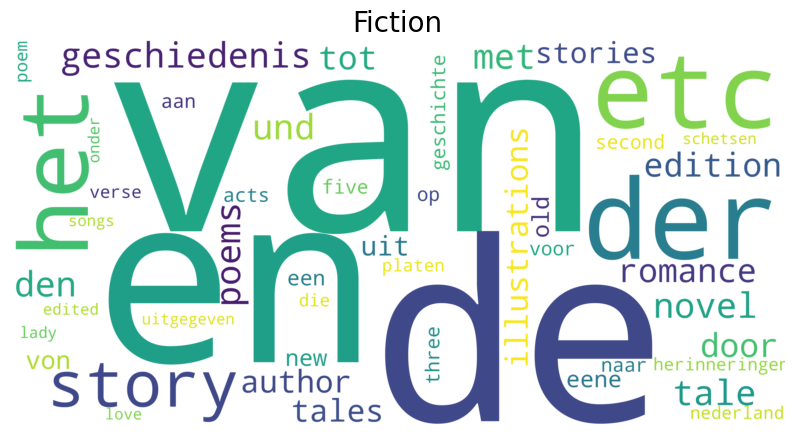

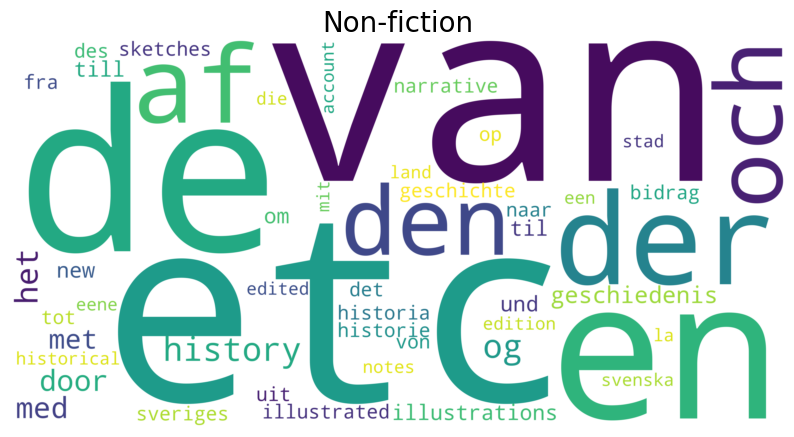

In [ ]:
# WordCloud
for label in LABELS:
    tokens = (
        token_df.where(F.col(LABEL_COL) == label)
        .select(F.explode("filtered_tokens").alias("token"))
        .where(F.col("token").rlike(r"^\w+$"))
    )

    top50_tokens = (
        tokens.groupBy("token").count().orderBy(F.desc("count")).limit(50).collect()
    )

    # Generate a word cloud image
    wordcloud = WordCloud(
        scale=10,
        background_color="white",
        random_state=42,  # Make sure the output is always the same for the same input
    ).generate_from_frequencies(dict(top50_tokens))

    # Display the generated image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.title(label, fontsize=20)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")

Finally, use `word2vec` to vectorize the text. `word2vec` creates a representation of each word present in your text into a vector. Words used in similar contexts or having semantic relationships are captured effectively through their closeness in the vector space, indicating that similar words have similar word vectors.

In [ ]:
# Label transformer
label_indexer = StringIndexer(inputCol=LABEL_COL, outputCol="labelIdx")
vectorizer = Word2Vec(
    vectorSize=word2vec_size,
    minCount=min_word_count,
    inputCol="filtered_tokens",
    outputCol="features",
)

# Build the pipeline
pipeline = Pipeline(stages=[label_indexer, vectorizer])
vec_df = (
    pipeline.fit(token_df)
    .transform(token_df)
    .select([TEXT_COL, LABEL_COL, "features", "labelIdx", "weight"])
)

display(vec_df.limit(20))

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 35, Finished, Available)

SynapseWidget(Synapse.DataFrame, 757b0816-7f29-40e4-bfd4-2fd47ad3d25d)

## Step 4: Model training and evaluation

With your data in place, now define the model. In this section, train a logistic regression model to classify the vectorized text.

### Prepare training and test datasets

In [ ]:
# Split the dataset into training and test sets
(train_df, test_df) = vec_df.randomSplit((0.8, 0.2), seed=42)

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 36, Finished, Available)

### Model training and machine learning experiments

A machine learning experiment is the primary unit of organization and control for all related machine learning runs. A run corresponds to a single execution of model code. Machine learning experiment tracking refers to the process of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts. Tracking enables you to organize all the required components of a specific machine learning experiment and to easily reproduce past results using saved experiments. Learn more about [machine learning experiments in Microsoft Fabric](https://aka.ms/synapse-experiment).


In [ ]:
# Build the logistic regression classifier
lr = (
    LogisticRegression()
    .setMaxIter(max_iter)
    .setFeaturesCol("features")
    .setLabelCol("labelIdx")
    .setWeightCol("weight")
)

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 37, Finished, Available)

### Model training and hyperparameter tuning

Construct a grid of parameters to search over the hyperparameters and a cross evaluator estimator to produce a CrossValidatorModel.

In [ ]:
# Construct a grid search to select the best values for the training parameters
param_grid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.03, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.1])
    .build()
)

if len(LABELS) > 2:
    evaluator_cls = MulticlassClassificationEvaluator
    evaluator_metrics = ["f1", "accuracy"]
else:
    evaluator_cls = BinaryClassificationEvaluator
    evaluator_metrics = ["areaUnderROC", "areaUnderPR"]
evaluator = evaluator_cls(labelCol="labelIdx", weightCol="weight")

# Construct a cross evaluator estimator
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=k_folds,
    collectSubModels=True,
)

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 38, Finished, Available)

### Model evaluation

You now have different models to compare by evaluating them on the test dataset. If a model has been well trained, it should demonstrate high performance on the relevant metrics on the validation and test datasets.

In [ ]:
def evaluate(model, df):
    log_metric = {}
    prediction = model.transform(df)
    for metric in evaluator_metrics:
        value = evaluator.evaluate(prediction, {evaluator.metricName: metric})
        log_metric[metric] = value
        print(f"{metric}: {value:.4f}")
    return prediction, log_metric

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 39, Finished, Available)

### Experiment tracking with MLflow

Start the training and evaluation and use MLflow to track all experiments and log parameters, metrics, and the models. All this information is logged under the experiment name in the workspace.

In [ ]:
with mlflow.start_run(run_name="lr"):
    models = crossval.fit(train_df)
    best_metrics = {k: 0 for k in evaluator_metrics}
    best_index = 0
    for idx, model in enumerate(models.subModels[0]):
        with mlflow.start_run(nested=True, run_name=f"lr_{idx}") as run:
            print("\nEvaluating on testing data:")
            print(f"subModel No. {idx + 1}")
            prediction, log_metric = evaluate(model, test_df)

            if log_metric[evaluator_metrics[0]] > best_metrics[evaluator_metrics[0]]:
                best_metrics = log_metric
                best_index = idx

            print("log model")
            mlflow.spark.log_model(
                model,
                f"{EXPERIMENT_NAME}-lrmodel",
                registered_model_name=f"{EXPERIMENT_NAME}-lrmodel",
                dfs_tmpdir="Files/spark",
            )

            print("log metrics")
            mlflow.log_metrics(log_metric)

            print("log parameters")
            mlflow.log_params(
                {
                    "word2vec_size": word2vec_size,
                    "min_word_count": min_word_count,
                    "max_iter": max_iter,
                    "k_folds": k_folds,
                    "DATA_FILE": DATA_FILE,
                }
            )

    # Log the best model and its relevant metrics and parameters to the parent run
    mlflow.spark.log_model(
        models.subModels[0][best_index],
        f"{EXPERIMENT_NAME}-lrmodel",
        registered_model_name=f"{EXPERIMENT_NAME}-lrmodel",
        dfs_tmpdir="Files/spark",
    )
    mlflow.log_metrics(best_metrics)
    mlflow.log_params(
        {
            "word2vec_size": word2vec_size,
            "min_word_count": min_word_count,
            "max_iter": max_iter,
            "k_folds": k_folds,
            "DATA_FILE": DATA_FILE,
        }
    )


StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 40, Finished, Available)


Evaluating on testing data:
subModel No. 1
areaUnderROC: 0.7435
areaUnderPR: 0.6555
log model
log metrics
log parameters

Evaluating on testing data:
subModel No. 2
areaUnderROC: 0.7295
areaUnderPR: 0.6581
log model
log metrics
log parameters

Evaluating on testing data:
subModel No. 3
areaUnderROC: 0.7338
areaUnderPR: 0.6542
log model
log metrics
log parameters

Evaluating on testing data:
subModel No. 4
areaUnderROC: 0.7139
areaUnderPR: 0.6411
log model
log metrics
log parameters


2023/09/05 17:21:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpnskxxpxj/model, flavor: spark), fall back to return ['pyspark==3.3.1']. Set logging level to DEBUG to see the full traceback.
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'sample-aisample-textclassification-lrmodel'.
2023/09/05 17:21:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sample-aisample-textclassification-lrmodel, version 1
Created version '1' of model 'sample-aisample-textclassification-lrmodel'.
2023/09/05 17:22:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpd4cq_jn2/model, 

To view your experiments:

1. On the left, select your workspace.
1. Find and select the experiment name, in this case _sample_aisample-textclassification_.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/Title_Genre_Classification/TextClassification-experiment.png"  width="70%" height="30%" title="Screenshot of an experiment.">

## Step 5: Score and save prediction results

Microsoft Fabric offers a scalable function called PREDICT that supports batch scoring in any compute engine and enables customers to operationalize machine learning models. You can create batch predictions straight from a notebook or the item page for a particular model. Learn more about [PREDICT](https://aka.ms/fabric-predict) and how to use it in Microsoft Fabric.

From the above evaluation results, model 1 has the largest Area Under the Precision-Recall Curve (AUPRC) and Area Under the Curve Receiver Operating Characteristic (AUC-ROC) metrics. Thus you should use model 1 for prediction.

The AUC-ROC measure is widely used to assess the performance of binary classifiers. However, sometimes, it's more appropriate to evaluate the classifier based on measuring AUPRC. AUC-ROC is a chart that visualizes the trade-off between true positive rate (TPR) and false positive rate (FPR). AUPRC is a curve that combines precision (positive predictive value or PPV) and Recall (true positive rate or TPR) in a single visualization.


In [ ]:
# Load the best model
model_uri = f"models:/{EXPERIMENT_NAME}-lrmodel/1"
loaded_model = mlflow.spark.load_model(model_uri, dfs_tmpdir="Files/spark")

# Verify the loaded model
batch_predictions = loaded_model.transform(test_df)
batch_predictions.show(5)

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 41, Finished, Available)

2023/09/05 17:23:05 INFO mlflow.spark: 'models:/sample-aisample-textclassification-lrmodel/1' resolved as 'abfss://acecfceb-abf7-4daa-b5a2-794d4b536a8f@msit-onelake.dfs.fabric.microsoft.com/da3d040a-1492-4c07-bc26-8bafbfe63512/b7008d5f-5660-4a24-932c-52f4a5a4a1e3/artifacts'
2023/09/05 17:23:06 INFO mlflow.spark: File 'abfss://acecfceb-abf7-4daa-b5a2-794d4b536a8f@msit-onelake.dfs.fabric.microsoft.com/da3d040a-1492-4c07-bc26-8bafbfe63512/b7008d5f-5660-4a24-932c-52f4a5a4a1e3/artifacts/sparkml' is already on DFS, copy is not necessary.


+--------------------+---------------+--------------------+--------+------------------+--------------------+--------------------+----------+
|               Title|annotator_genre|            features|labelIdx|            weight|       rawPrediction|         probability|prediction|
+--------------------+---------------+--------------------+--------+------------------+--------------------+--------------------+----------+
|Physical, histori...|    Non-fiction|[-0.0075448265549...|     0.0|               1.0|[0.63629026017003...|[0.65391438810354...|       0.0|
|Beschrijving van ...|    Non-fiction|[-0.0226123829022...|     0.0|               1.0|[-0.6157430269028...|[0.35075025155754...|       1.0|
|Squibs and Cracke...|        Fiction|[-7.8669276886752...|     1.0|2.9563218390804598|[-0.7050312880964...|[0.33069767198117...|       1.0|
|The New Far East ...|    Non-fiction|[-0.0123122965451...|     0.0|               1.0|[1.17229123886848...|[0.76355891818826...|       0.0|
|Aus Böhmen n

In [ ]:
# Code to save the userRecs into lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions"
)

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 42, Finished, Available)

In [ ]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 3fd88b16-e905-4c38-99da-16b9b46411b3, 43, Finished, Available)

Full run cost 499 seconds.
